In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os
sys.path.append("../../")
from neurotools.emg_tools.hd_sEMG import NeuroNexus_H32_tri,NeuroNexus_H32_tri_interp,HD_sEMG,interpolate_HD_sEMG, array_grid
from neurotools.emg_tools.emg_channel import eEMG
from neurotools.ns5_tools.ns5_tools import ns5Files
from neurotools.utils.trigger import trigger as trigger_b

##  Open a file and create an HD_sEMG object, and interpolate it

In [2]:
##create or open the EMG arrays
keys = NeuroNexus_H32_tri.required_raw_keys() + ['Tr0 ', 'Tr1 ']

data_file = "./source/test_emg_array.hdf5"
overwrite = False
if not (os.path.isfile(data_file)) or overwrite:
    ns5_path = "./source/UA015_SEL_MS_AS_SGM1_0016.ns5"
    ns5_file = ns5Files(ns5_path)
    if set(keys).issubset(ns5_file.get_analog_entitie_labels()):
        ns5_file.to_hdf(data_file,keys)
    else:
        print("Requested keys not available")
        exit()

df_emg = pd.read_hdf(data_file)
HD_sEMG_no_interp = HD_sEMG(df = df_emg, array = NeuroNexus_H32_tri)   

hd_sEMG = interpolate_HD_sEMG(HD_sEMG_no_interp, NeuroNexus_H32_tri_interp, raw = False)      #interpolate from raw data   
hd_sEMG.filter_eEMGs(f_LPF = 10_000, f_HPF = 10, n_LPF = 5, n_HFP = 5)                        #filter orignal data 
trigger = trigger_b(df_emg['Tr0 '],df_emg['time'])         #add a trigger
hd_sEMG.trigger = trigger
del HD_sEMG_no_interp

## Plot original raw and interpolated raw EMGs

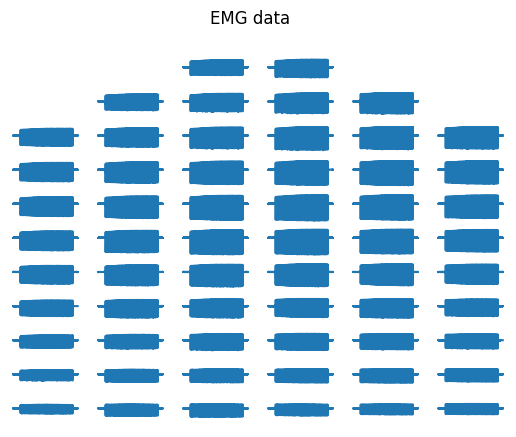

In [3]:
hd_sEMG.plot_data(label=False)
plt.show()

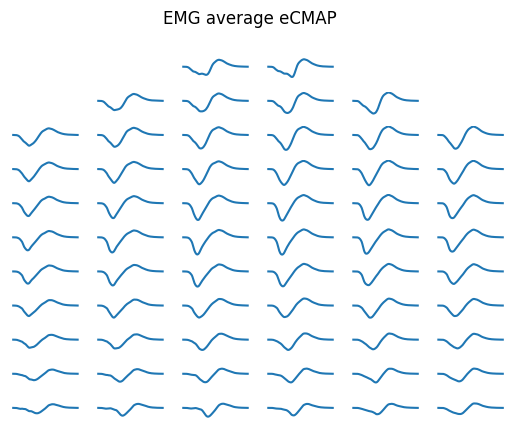

In [4]:
hd_sEMG.get_eCMAPS(duration = 0.015, delay = 0.001)
hd_sEMG.plot_avg_eCMAP(label=False)
plt.show()

## Testing spatial filtering

### Basic convolve filters

In [5]:
from scipy.ndimage import convolve
import neurotools.emg_tools.spatial_filtering as sp 

test_array = np.array(
             [[1   ,2   ,3   ,4   ,5],
              [10  ,20  ,30  ,40  ,50],
              [100 ,200 ,300 ,400 ,500],
              [1000,2000,3000,4000,5000]])

print(( test_array == convolve(test_array, sp.unit_kernel(), mode='nearest')).all())
print(( -1*test_array == convolve(test_array, sp.reverse_kernel(), mode='nearest')).all())

True
True


### 1D Simple Differential Filters

In [6]:
def sp_TSD(data_2D):
    new_data =  np. empty_like(data_2D)
    data_copy=np.hstack((data_2D, np.tile(data_2D[:, [-1]], 1)))
    for iy, ix in np.ndindex(data_2D.shape):
        new_data[iy, ix] = - data_copy[iy,ix+1] + data_copy[iy, ix]
    return(new_data)

def sp_LSD(data_2D):
    new_data =  np.empty_like(data_2D)
    data_copy=np.vstack((data_2D, np.tile(data_2D[[-1], :], 1)))
    for iy, ix in np.ndindex(data_2D.shape):
            new_data[iy, ix] = - data_copy[iy+1,ix] + data_copy[iy, ix]
    return(new_data)


print((sp_TSD(test_array) == convolve(test_array, sp.TSD_kernel(), mode='nearest')).all())
print((sp_LSD(test_array) == convolve(test_array, sp.LSD_kernel(), mode='nearest')).all())

True
True


### 1D Double Differential Filters

In [7]:
def sp_LDD(data_2D):
    new_data =  np. empty_like(data_2D)
    data_copy=np.vstack((data_2D, np.tile(data_2D[[-1], :], 1)))
    data_copy=np.vstack((np.tile(data_copy[[0], :], 1),data_copy))
    for iy, ix in np.ndindex(data_2D.shape):
            new_data[iy, ix] =  2*data_copy[iy+1, ix] - data_copy[iy+2, ix] - data_copy[iy,ix] 
    return(new_data)

def sp_TDD(data_2D):
    new_data =  np. empty_like(data_2D)
    data_copy=np.hstack((data_2D, np.tile(data_2D[:, [-1]], 1)))
    data_copy=np.hstack((np.tile(data_copy[:, [0]], 1),data_copy))
    for iy, ix in np.ndindex(data_2D.shape):
            new_data[iy, ix] =  2*data_copy[iy, ix+1] - data_copy[iy, ix+2] - data_copy[iy,ix] 
    return(new_data)

print((sp_LDD(test_array) == convolve(test_array, sp.LDD_kernel(), mode='nearest')).all())
print((sp_TDD(test_array) == convolve(test_array, sp.TDD_kernel(), mode='nearest')).all())

True
True


### 2D Double Differential Filters

In [8]:

def sp_NDD(data_2D):
    new_data =  np. empty_like(data_2D)
    data_copy=np.vstack((data_2D, np.tile(data_2D[[-1], :], 1)))
    data_copy=np.hstack((data_copy, np.tile(data_copy[:, [-1]], 1)))
    data_copy=np.vstack((np.tile(data_copy[[0], :], 1),data_copy))
    data_copy=np.hstack((np.tile(data_copy[:, [0]], 1),data_copy))
    for iy, ix in np.ndindex(data_2D.shape):
            new_data[iy, ix] =  4*data_copy[iy+1, ix+1] - data_copy[iy+2, ix+1] - data_copy[iy+1, ix] - data_copy[iy+1, ix+2] - data_copy[iy,ix+1] 
    return(new_data)

def sp_IB2(data_2D):
    new_data =  np. empty_like(data_2D)
    data_copy=np.vstack((data_2D, np.tile(data_2D[[-1], :], 1)))
    data_copy=np.hstack((data_copy, np.tile(data_copy[:, [-1]], 1)))
    data_copy=np.vstack((np.tile(data_copy[[0], :], 1),data_copy))
    data_copy=np.hstack((np.tile(data_copy[:, [0]], 1),data_copy))
    for iy, ix in np.ndindex(data_2D.shape):
            new_data[iy, ix] =  12*data_copy[iy+1, ix+1] - 2*data_copy[iy+2, ix+1] - 2*data_copy[iy+1, ix] - 2*data_copy[iy+1, ix+2] - 2*data_copy[iy,ix+1] -data_copy[iy, ix]-data_copy[iy, ix+2]-data_copy[iy+2, ix+2]-data_copy[iy+2, ix]
            new_data[iy, ix] *= (1/16)
    return(new_data)

def sp_IR(data_2D):
    new_data =  np. empty_like(data_2D)
    data_copy=np.vstack((data_2D, np.tile(data_2D[[-1], :], 1)))
    data_copy=np.hstack((data_copy, np.tile(data_copy[:, [-1]], 1)))
    data_copy=np.vstack((np.tile(data_copy[[0], :], 1),data_copy))
    data_copy=np.hstack((np.tile(data_copy[:, [0]], 1),data_copy))
    for iy, ix in np.ndindex(data_2D.shape):
            new_data[iy, ix] =  8*data_copy[iy+1, ix+1] - data_copy[iy+2, ix+1] - data_copy[iy+1, ix] - data_copy[iy+1, ix+2] - data_copy[iy,ix+1]  -data_copy[iy, ix]-data_copy[iy, ix+2]-data_copy[iy+2, ix+2]-data_copy[iy+2, ix]
    return(np.int32(new_data*(1/9)))


print((sp_NDD(test_array) == convolve(test_array, sp.NDD_kernel(), mode='nearest')).all())
print((sp_IB2(test_array) == convolve(test_array, sp.IB2_kernel(), mode='nearest')).all())
print((sp_IR(test_array) == convolve(test_array, sp.IR_kernel(), mode='nearest')).all())


True
True
False


# Implementation in Neurotools
## Generating news HD_sEMG objects with different filter configurations

In [9]:
raw = True
hd_semg_LSD = sp.spatial_filter(hd_sEMG,sp.LSD_kernel,raw = raw)
hd_semg_TSD = sp.spatial_filter(hd_sEMG,sp.TSD_kernel,raw = raw)
hd_semg_LDD = sp.spatial_filter(hd_sEMG,sp.LDD_kernel,raw = raw)
hd_semg_TDD = sp.spatial_filter(hd_sEMG,sp.TDD_kernel,raw = raw)
hd_semg_NDD = sp.spatial_filter(hd_sEMG,sp.NDD_kernel,raw = raw)
hd_semg_IB2 = sp.spatial_filter(hd_sEMG,sp.IB2_kernel,raw = raw)
hd_semg_IR = sp.spatial_filter(hd_sEMG,sp.IR_kernel,raw = raw)


hd_semg_LSD.filter_eEMGs(f_LPF = 10_000, f_HPF = 10, n_LPF = 5, n_HFP = 5)                         
hd_semg_TSD.filter_eEMGs(f_LPF = 10_000, f_HPF = 10, n_LPF = 5, n_HFP = 5)                         
hd_semg_LDD.filter_eEMGs(f_LPF = 10_000, f_HPF = 10, n_LPF = 5, n_HFP = 5)                         
hd_semg_TDD.filter_eEMGs(f_LPF = 10_000, f_HPF = 10, n_LPF = 5, n_HFP = 5)                         
hd_semg_NDD.filter_eEMGs(f_LPF = 10_000, f_HPF = 10, n_LPF = 5, n_HFP = 5)                         
hd_semg_IB2.filter_eEMGs(f_LPF = 10_000, f_HPF = 10, n_LPF = 5, n_HFP = 5)                         
hd_semg_IR.filter_eEMGs(f_LPF = 10_000, f_HPF = 10, n_LPF = 5, n_HFP = 5)                         

## Plotting the new electrode grid arrays

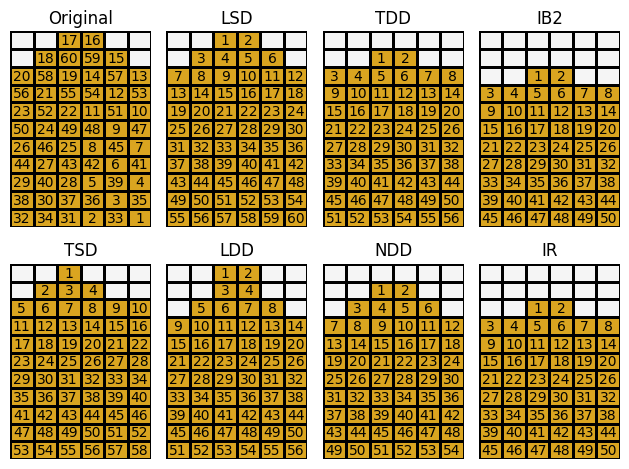

In [10]:

fig, axs = plt.subplots(2,4) 
hd_sEMG.array.plot_grid(axs[0,0])
hd_semg_LSD.array.plot_grid(axs[0,1])
hd_semg_TSD.array.plot_grid(axs[1,0])
hd_semg_LDD.array.plot_grid(axs[1,1])
hd_semg_TDD.array.plot_grid(axs[0,2])
hd_semg_NDD.array.plot_grid(axs[1,2])
hd_semg_IB2.array.plot_grid(axs[0,3])
hd_semg_IR.array.plot_grid(axs[1,3])

axs[0,0].set_title("Original")
axs[0,1].set_title("LSD")
axs[1,0].set_title("TSD")
axs[1,1].set_title("LDD")
axs[0,2].set_title("TDD")
axs[1,2].set_title("NDD")
axs[0,3].set_title("IB2")
axs[1,3].set_title("IR")

for x in axs:
  for ax in x:
    ax.set_axis_off()

fig.tight_layout()
plt.show()


## Validating filtered data

### 1D filters

False
False
False
False


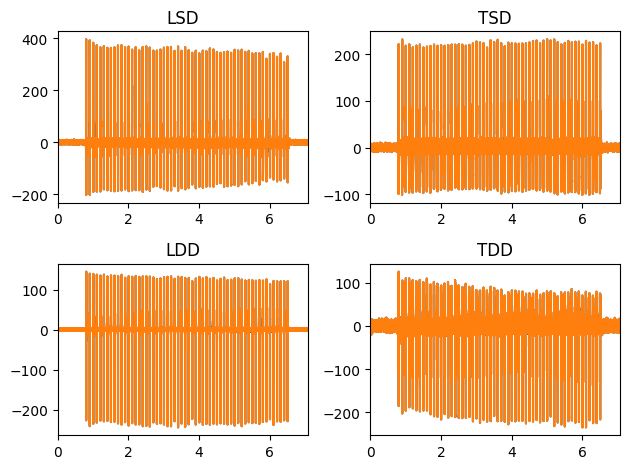

In [16]:

fig, axs = plt.subplots(2,2) 

#LSD: e14_LSD = e21_o - e52_o
e_LSD = 14
filtered = hd_sEMG.get_eEMG(21).data-hd_sEMG.get_eEMG(52).data
axs[0,0].plot(hd_sEMG.get_eEMG(e_LSD).t,filtered)
hd_semg_LSD.get_eEMG(e_LSD).plot(axs[0,0])
print((hd_semg_LSD.get_eEMG(e_LSD) .data == filtered).all())
axs[0,0].set_title("LSD")

#TSD: e11_TSD = e21_o - e55_o
e_TSD = 11
filtered = hd_sEMG.get_eEMG(56).data-hd_sEMG.get_eEMG(21).data
axs[0,1].plot(hd_sEMG.get_eEMG(e_TSD).t,filtered)
hd_semg_TSD.get_eEMG(e_TSD).plot(axs[0,1])
print((hd_semg_TSD.get_eEMG(e_TSD) .data == filtered).all())
axs[0,1].set_title("TSD")

#LDD: e11_LDD = 2*e_o55 - e19_o - e22_o
e_LDD = 11
filtered = 2*hd_sEMG.get_eEMG(55).data-hd_sEMG.get_eEMG(19).data-hd_sEMG.get_eEMG(22).data
axs[1,0].plot(hd_sEMG.get_eEMG(e_LDD).t,filtered)
hd_semg_LDD.get_eEMG(e_LDD).plot(axs[1,0])
print((hd_semg_LDD.get_eEMG(e_LDD).data == filtered).all())
axs[1,0].set_title("LDD")

#TDD: e11_LDD = 2*e_o55 - e21_o - e54_o
e_TDD = 11
filtered = 2*hd_sEMG.get_eEMG(55).data-hd_sEMG.get_eEMG(21).data-hd_sEMG.get_eEMG(54).data
axs[1,1].plot(hd_sEMG.get_eEMG(e_TDD).t,filtered)
hd_semg_TDD.get_eEMG(e_TDD).plot(axs[1,1])
print((hd_semg_TDD.get_eEMG(e_TDD).data == filtered).all())
axs[1,1].set_title("TDD")


for x in axs:
  for ax in x:
    ax.set_xlabel("")
    ax.set_ylabel("")
fig.tight_layout()

### 2D filters

False
False
False


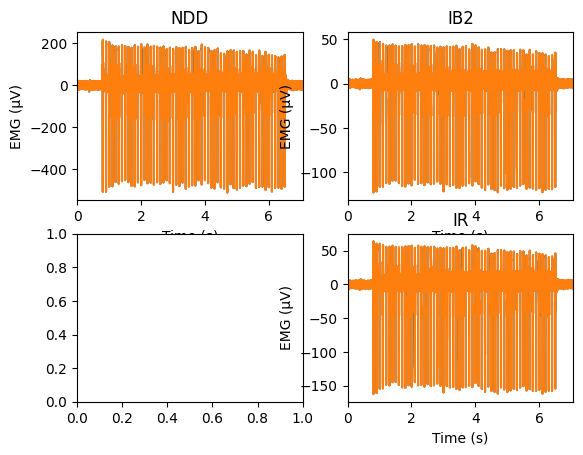

In [17]:
fig, axs = plt.subplots(2,2) 

#NDD filter
e_NDD = 15
filtered = 4*hd_sEMG.get_eEMG(22).data-hd_sEMG.get_eEMG(52).data-hd_sEMG.get_eEMG(55).data-hd_sEMG.get_eEMG(11).data-hd_sEMG.get_eEMG(49).data
axs[0,0].plot(hd_sEMG.get_eEMG(e_NDD).t,filtered)
hd_semg_NDD.get_eEMG(e_NDD).plot(axs[0,0])
print((hd_semg_NDD.get_eEMG(e_NDD).data == filtered).all())
axs[0,0].set_title("NDD")

#IB2
e_IB2 = 11
filtered = 12*hd_sEMG.get_eEMG(22).data-2*hd_sEMG.get_eEMG(52).data-2*hd_sEMG.get_eEMG(55).data-2*hd_sEMG.get_eEMG(11).data-2*hd_sEMG.get_eEMG(49).data 
filtered+= -hd_sEMG.get_eEMG(21).data - hd_sEMG.get_eEMG(54).data - hd_sEMG.get_eEMG(48).data - hd_sEMG.get_eEMG(24).data
filtered/=16
axs[0,1].plot(hd_sEMG.get_eEMG(e_IB2).t,filtered)
hd_semg_IB2.get_eEMG(e_IB2).plot(axs[0,1])
print((hd_semg_IB2.get_eEMG(e_IB2).data == filtered).all())
axs[0,1].set_title("IB2")

#IR
e_IR = 11
filtered = 8*hd_sEMG.get_eEMG(22).data-hd_sEMG.get_eEMG(52).data-hd_sEMG.get_eEMG(55).data-hd_sEMG.get_eEMG(11).data-hd_sEMG.get_eEMG(49).data 
filtered+= -hd_sEMG.get_eEMG(21).data - hd_sEMG.get_eEMG(54).data - hd_sEMG.get_eEMG(48).data - hd_sEMG.get_eEMG(24).data
filtered/=9
axs[1,1].plot(hd_sEMG.get_eEMG(e_IR).t,filtered)
hd_semg_IR.get_eEMG(e_IR).plot(axs[1,1])
axs[1,1].set_title("IR")
print((hd_semg_IR.get_eEMG(e_IR).raw == filtered).all())



# Comparing Filters

## 1D filters

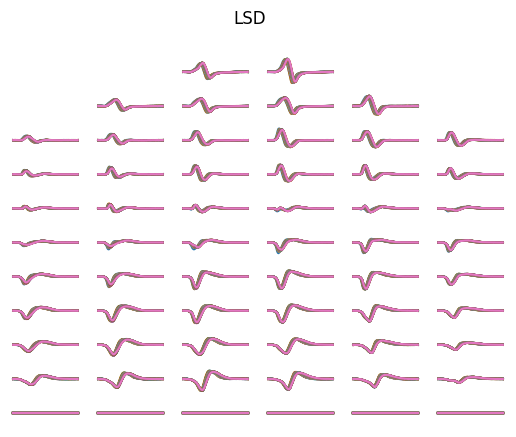

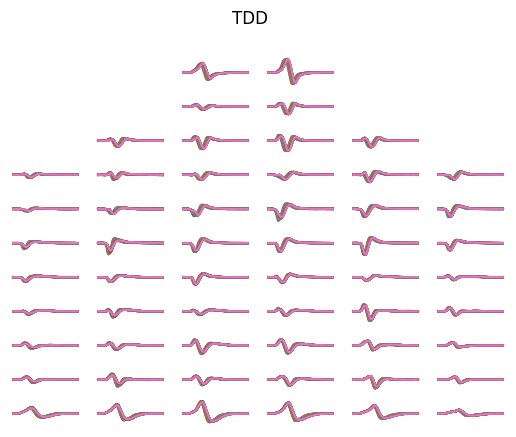

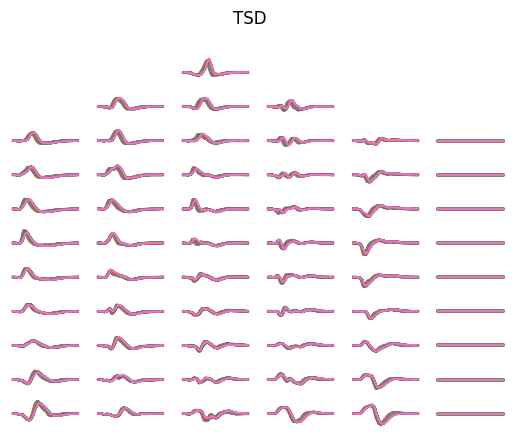

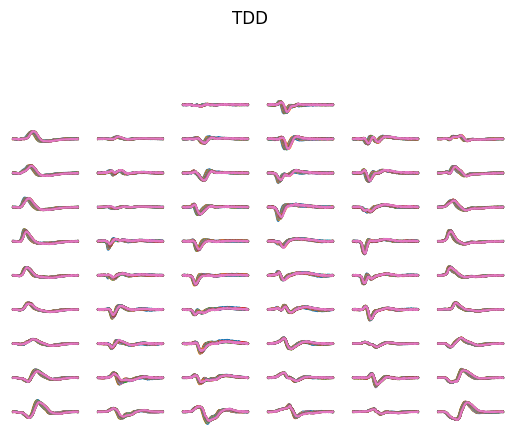

In [18]:
#todo: 
#faire un test LSD/TSD etc from uninterpolated data
#move to spatial filtering
#get min_max of any data
#normal to max row/data/ecap/avg_ecap ???



hd_semg_LSD.get_eCMAPS(duration = 0.015, delay = 0.001)
fig,_ = hd_semg_LSD.plot_eCMAPs(label=False)
fig.suptitle("LSD")

hd_semg_LDD.get_eCMAPS(duration = 0.015, delay = 0.001)
fig,_ = hd_semg_LDD.plot_eCMAPs(label=False)
fig.suptitle("TDD")

hd_semg_TSD.get_eCMAPS(duration = 0.015, delay = 0.001)
fig,_ = hd_semg_TSD.plot_eCMAPs(label=False)
fig.suptitle("TSD")

hd_semg_TDD.get_eCMAPS(duration = 0.015, delay = 0.001)
fig,_ = hd_semg_TDD.plot_eCMAPs(label=False)
fig.suptitle("TDD")


print()

## 2D Filters

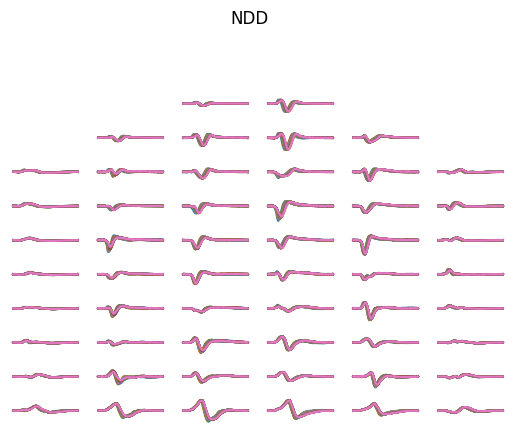

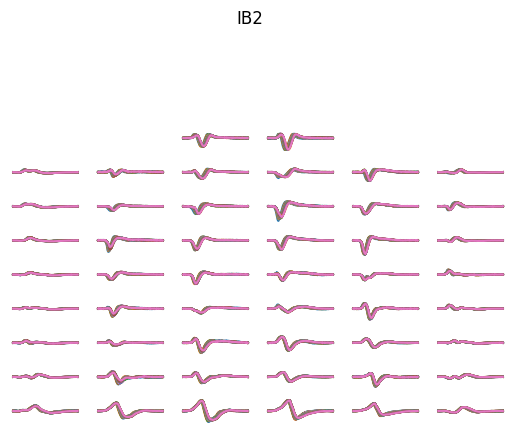

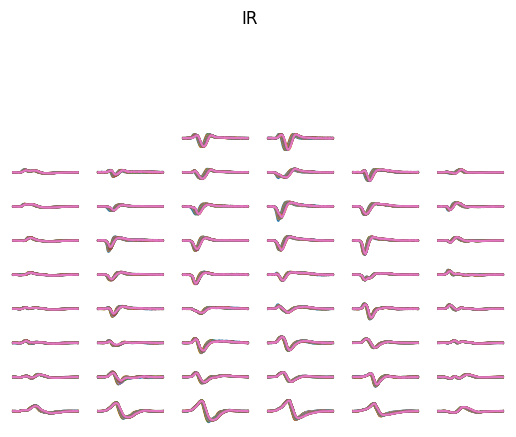

In [19]:
hd_semg_NDD.get_eCMAPS(duration = 0.015, delay = 0.001)
fig,_ = hd_semg_NDD.plot_eCMAPs(label=False)
fig.suptitle("NDD")

hd_semg_IB2.get_eCMAPS(duration = 0.015, delay = 0.001)
fig,_ = hd_semg_IB2.plot_eCMAPs(label=False)
fig.suptitle("IB2")

hd_semg_IR.get_eCMAPS(duration = 0.015, delay = 0.001)
fig,_ = hd_semg_IR.plot_eCMAPs(label=False)
fig.suptitle("IR")

print()

## Plot Heatmaps etc

In [ ]:
def plot_heatmap(list_hd_semg, data):
    fig, axs = plt.subplots(1,len(list_hd_semg)) 
    for i,hd_emg in enumerate(list_hd_semg):
        sc = hd_emg.plot_heatmap_eCMAP(axs[i], data, n_interp = 100)
        axs[i].set_title(hd_emg.sp_kernel.label)
    fig.colorbar(sc, ax = axs[i])
    fig.suptitle(f"eCMUAP characteristic: {data}")
    fig.set_size_inches(10,5)
    fig.tight_layout()

#plt.rcParams['figure.figsize'] = [10, 5]
data_1D = [hd_semg_LSD,hd_semg_LDD,hd_semg_TSD,hd_semg_TDD]
data_2D = [hd_semg_NDD,hd_semg_IR,hd_semg_IB2]
plot_heatmap(data_1D,"rms")
plot_heatmap(data_2D,"rms")

plot_heatmap(data_1D,"peak2peak")
plot_heatmap(data_2D,"peak2peak")

plot_heatmap(data_1D,"latency")
plot_heatmap(data_2D,"latency")

plot_heatmap(data_1D,"duration")
plot_heatmap(data_2D,"duration")

plot_heatmap(data_1D,"ttmax")
plot_heatmap(data_2D,"ttmax")

plot_heatmap(data_1D,"ttmin")
plot_heatmap(data_2D,"ttmin")


## 1D filter fig

In [ ]:
min = -50
max = 50
n_interp = 15
def animate(i):
    fig, axs = plt.subplots(2,2,subplot_kw={"projection": "3d"})
    axs[0,0].set_zlim([min, max])
    axs[0,1].set_zlim([min, max])
    axs[1,0].set_zlim([min, max])
    axs[1,1].set_zlim([min, max])
    hd_semg_LSD.plot_avg_3D_timeshot(ax = axs[0,0], t_idx=i,n_interp = n_interp, min = min, max=max)
    hd_semg_LDD.plot_avg_3D_timeshot(ax = axs[0,1], t_idx=i,n_interp = n_interp, min = min, max=max)
    hd_semg_TSD.plot_avg_3D_timeshot(ax = axs[1,0], t_idx=i,n_interp = n_interp, min = min, max=max)
    hd_semg_TDD.plot_avg_3D_timeshot(ax = axs[1,1], t_idx=i,n_interp = n_interp, min = min, max=max)
    return(fig)

t = hd_semg_LSD.eEMGs[0].avg_eCMAP.t

from neurotools.utils.plots import create_gif
create_gif(animate,len(t),"outputs/emg_array_1D_filters.gif")

In [ ]:
min = -120
max = 120
n_interp = 15
def animate(i):
    fig, axs = plt.subplots(1,3,subplot_kw={"projection": "3d"})
    axs[0].set_zlim([min, max])
    axs[1].set_zlim([min, max])
    axs[2].set_zlim([min, max])
    hd_semg_NDD.plot_avg_3D_timeshot(ax = axs[0], t_idx=i,n_interp = n_interp, min = min, max=max)
    hd_semg_IR.plot_avg_3D_timeshot(ax = axs[1], t_idx=i,n_interp = n_interp, min = min, max=max)
    hd_semg_IB2.plot_avg_3D_timeshot(ax = axs[2], t_idx=i,n_interp = n_interp, min = min, max=max)
    return(fig)

t = hd_semg_IB2.eEMGs[0].avg_eCMAP.t

from neurotools.utils.plots import create_gif
create_gif(animate,len(t),"outputs/emg_array_2D_filters.gif")


In [ ]:
min = -200
max = 200
n_interp = 25
def animate(i):
    fig, ax = plt.subplots(1,subplot_kw={"projection": "3d"})
    #axs[0].set_zlim([min, max])
    #axs[1].set_zlim([min, max])
    #axs[2].set_zlim([min, max])
    ax.set_zlim([min, max])
    hd_semg_IB2.plot_avg_3D_timeshot(ax = ax, t_idx=i,n_interp = n_interp, min = min, max=max)
    #hd_semg_IR.plot_avg_3D_timeshot(ax = axs[1], t_idx=i,n_interp = n_interp, min = min, max=max)
    #hd_semg_IB2.plot_avg_3D_timeshot(ax = axs[2], t_idx=i,n_interp = n_interp, min = min, max=max)
    return(fig)

t = hd_semg_IB2.eEMGs[0].avg_eCMAP.t

from neurotools.utils.plots import create_gif
create_gif(animate,len(t),"outputs/emg_array_IB2.gif")